In [ ]:
from langchain.chat_models import AzureChatOpenAI

llm = AzureChatOpenAI(
    deployment_name="your-deployment-name",
    openai_api_version="2023-07-01-preview",
    openai_api_key="your-api-key",
    azure_endpoint="your-azure-endpoint"
)

/tmp/ipykernel_36135/2916875354.py:3: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm = AzureChatOpenAI(


In [ ]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import create_react_agent
from langchain.prompts import PromptTemplate
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.tools import tool
import json

In [3]:
@tool
def generate_questions(job_title: str) -> str:
    """Generates 5 interview questions for a given job title."""
    prompt = PromptTemplate.from_template(
        "Generate 5 interview questions for a {job_title} role."
    )
    return llm.invoke(prompt.format(job_title=job_title)).content


In [4]:
@tool
def evaluate_answer(question: str, answer: str) -> dict:
    """Evaluates an interview answer for correctness, clarity, and completeness."""
    prompt = PromptTemplate.from_template(
        """Evaluate the following interview response on a scale of 1-10 for:
        - Correctness
        - Clarity
        - Completeness
        
        Question: {question}
        Answer: {answer}

        Provide a JSON output in this format:
        {{
            "correctness": <score>,
            "clarity": <score>,
            "completeness": <score>
        }}
        """
    )

    structured_parser = StructuredOutputParser.from_response_schemas([
        ResponseSchema(name="correctness", description="Correctness score"),
        ResponseSchema(name="clarity", description="Clarity score"),
        ResponseSchema(name="completeness", description="Completeness score"),
    ])

    llm_response = llm.invoke(prompt.format(question=question, answer=answer))
    
    try:
        return json.loads(llm_response.content)  # Convert JSON string to dict
    except json.JSONDecodeError:
        return {"correctness": 5, "clarity": 5, "completeness": 5}  # Default values


In [5]:
@tool
def provide_feedback(question: str, answer: str) -> str:
    """Provides constructive feedback based on evaluation scores for an interview answer."""
    eval_scores = evaluate_answer(question, answer)

    prompt = PromptTemplate.from_template(
        """Based on the following interview response evaluation scores:
        - Correctness: {correctness}
        - Clarity: {clarity}
        - Completeness: {completeness}
        
        Provide constructive feedback and suggestions for improvement.

        Question: {question}
        Answer: {answer}
        """
    )

    return llm.invoke(prompt.format(**eval_scores, question=question, answer=answer)).content


In [6]:
class Router(TypedDict):
    """Determines the next agent to call."""
    next: Literal["question_generator", "answer_evaluator", "feedback_provider", "FINISH"]

system_prompt = (
    "You are a supervisor managing the following workers: Question Generator, "
    "Answer Evaluator, and Feedback Provider. Based on the user’s input, "
    "route the request to the appropriate agent. When all tasks are completed, return 'FINISH'."
)

In [7]:
# Define State
class State(MessagesState):
    next: str

# Supervisor Node (Routing)
def supervisor_node(state: State) -> Command[Literal["question_generator", "answer_evaluator", "feedback_provider", "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.invoke(messages)

    # Fixing the previous error (response is an AIMessage object, not a dict)
    response_content = response.content.strip().lower()
    
    if "question" in response_content:
        goto = "question_generator"
    elif "evaluate" in response_content:
        goto = "answer_evaluator"
    elif "feedback" in response_content:
        goto = "feedback_provider"
    else:
        goto = END

    return Command(goto=goto, update={"next": goto})

In [8]:
# Question Node
def question_node(state: State) -> Command[Literal["supervisor"]]:
    job_title = state["messages"][-1].content  # Extract job title
    result = generate_questions(job_title)  # Call the function manually
    return Command(update={"messages": [HumanMessage(content=result, name="question_generator")]}, goto="supervisor")

In [9]:
# Evaluation Node
def evaluation_node(state: State) -> Command[Literal["supervisor"]]:
    # Extracting question and answer from previous messages
    messages = state["messages"]
    question = messages[-2].content
    answer = messages[-1].content

    result = evaluate_answer(question, answer)  # Call the function manually
    return Command(update={"messages": [HumanMessage(content=str(result), name="answer_evaluator")]}, goto="supervisor")

In [10]:
# Feedback Node
def feedback_node(state: State) -> Command[Literal["supervisor"]]:
    messages = state["messages"]
    question = messages[-3].content
    answer = messages[-2].content

    result = provide_feedback(question, answer)  # Call the function manually
    return Command(update={"messages": [HumanMessage(content=result, name="feedback_provider")]}, goto="supervisor")

In [11]:
# Graph Construction
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("question_generator", question_node)
builder.add_node("answer_evaluator", evaluation_node)
builder.add_node("feedback_provider", feedback_node)

# Compile Graph
graph = builder.compile()

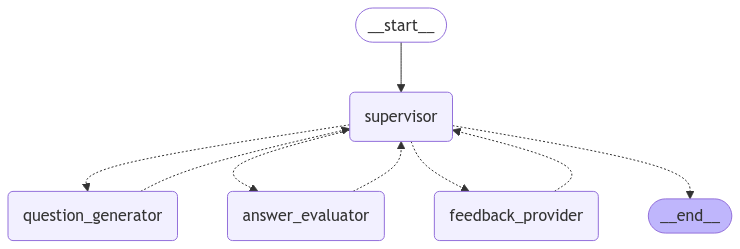

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Run Execution
for s in graph.stream({"messages": [("user", "I am preparing for a Data Scientist interview provide with few questions.")] }):
    print(s)
    print("----")

{'supervisor': {'next': 'question_generator'}}
----


/tmp/ipykernel_36135/398743952.py:4: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = generate_questions(job_title)  # Call the function manually


{'question_generator': {'messages': [HumanMessage(content="Certainly! Below are five interview questions that you can prepare for a Data Scientist role. These questions cover a mix of technical, problem-solving, and conceptual aspects of data science:\n\n---\n\n### **1. Explain a Machine Learning Project You've Worked On**\n   - **Follow-up Questions:**\n     - What was the problem you were solving, and how did you approach it?\n     - What algorithms and tools did you use, and why?\n     - How did you measure the performance of your model?\n     - What were the challenges, and how did you overcome them?\n\n---\n\n### **2. How Would You Handle Missing or Corrupted Data in a Dataset?**\n   - **Key Points to Cover:**\n     - Data cleaning techniques (e.g., imputation, dropping rows/columns).\n     - Identifying patterns in missing data.\n     - Trade-offs between different approaches and their impact on the analysis.\n\n---\n\n### **3. How Do You Choose the Right Machine Learning Algorit